In [1]:
import pandas as pd
import numpy as np
import datetime
import h5py
import pickle
from collections import defaultdict

from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (8, 6)

In [4]:
!python download_gdrive.py 1XyDCTcmNIrQh_CFWCsqjR3RVyYUDKX7O CTU-13-Dataset_onlyBiNetflowFiles.zip

download_gdrive.py:50: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(sys.argv) is not 3:
430MB [00:02, 171MB/s]  


In [2]:
!unzip CTU-13-Dataset_onlyBiNetflowFiles.zip

Archive:  CTU-13-Dataset_onlyBiNetflowFiles.zip
   creating: CTU-13-Dataset/
  inflating: CTU-13-Dataset/capture20110812.binetflow  
  inflating: CTU-13-Dataset/capture20110815-3.binetflow  
  inflating: CTU-13-Dataset/capture20110817.binetflow  
  inflating: CTU-13-Dataset/capture20110811.binetflow  
  inflating: CTU-13-Dataset/capture20110819.binetflow  
  inflating: CTU-13-Dataset/capture20110818-2.binetflow  
  inflating: CTU-13-Dataset/capture20110816-3.binetflow  
  inflating: CTU-13-Dataset/capture20110815.binetflow  
  inflating: CTU-13-Dataset/capture20110816-2.binetflow  
  inflating: CTU-13-Dataset/capture20110818.binetflow  
  inflating: CTU-13-Dataset/capture20110815-2.binetflow  
  inflating: CTU-13-Dataset/capture20110816.binetflow  
  inflating: CTU-13-Dataset/capture20110810.binetflow  


# 4. Data analysis
## 4.1. CTU-13 Dataset

- CTU-13 is a labeled dataset used in literature to train botnet detection model. It captures botnet traffic mixed with normal/ background one. In this section, we will describe the dataset to find out the relevant features to train our models

- CTU-13 is made of 13 captures of different botnet samples recorded in 13 Netflows files

![](https://images.squarespace-cdn.com/content/v1/5a01100f692ebe0459a1859f/1510069396377-GJO1XFHKN81I4TDATY77/ke17ZwdGBToddI8pDm48kJcuVvbb7dX4ccZHUBVbcIwUqsxRUqqbr1mOJYKfIPR7LoDQ9mXPOjoJoqy81S2I8N_N4V1vUb5AoIIIbLZhVYxCRW4BPu10St3TBAUQYVKcttMiPYt-q5WVyRRIAnCobGPZv7ziyEmNgwdexgi_1iiq_yDw7qYBNVpdhuyRQbv6/Table2.jpg?format=1500w)

- Our presentation woulf focus on first scenario which is made of $2.824.636$ bidirectional communications described by 15 features

In [2]:
data = pd.read_csv('CTU-13-Dataset/capture20110810.binetflow')
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,2011/08/10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,2011/08/10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,2011/08/10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt


In [8]:
data['StartTime'] = pd.to_datetime(data['StartTime'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824636 entries, 0 to 2824635
Data columns (total 15 columns):
 #   Column     Dtype         
---  ------     -----         
 0   StartTime  datetime64[ns]
 1   Dur        float64       
 2   Proto      object        
 3   SrcAddr    object        
 4   Sport      object        
 5   Dir        object        
 6   DstAddr    object        
 7   Dport      object        
 8   State      object        
 9   sTos       float64       
 10  dTos       float64       
 11  TotPkts    int64         
 12  TotBytes   int64         
 13  SrcBytes   int64         
 14  Label      object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(8)
memory usage: 323.3+ MB


In [10]:
data

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011-08-10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,Normal
1,2011-08-10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,Normal
2,2011-08-10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,Normal
3,2011-08-10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,Normal
4,2011-08-10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,Normal


1. Start time: Date of the flow start (from 2011/08/10 09:46:53 to 2011/08/10 15:54:07). The Start times of NetFlow seens uniformly distributed except at around 10:20 due to starting of Netflow

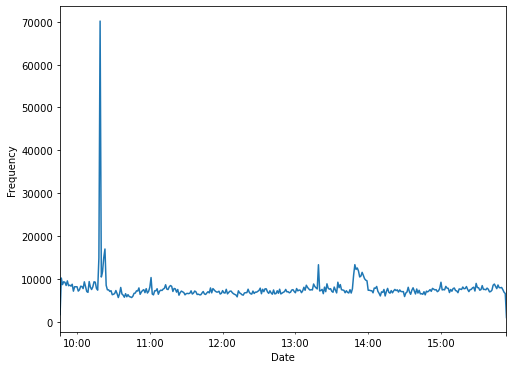

In [4]:
data.resample('T', on='StartTime').count()['StartTime'].plot()
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.savefig('Fig1.png')
plt.show()

In [5]:
data['StartTime'] = pd.to_datetime(data['StartTime']).values.astype('int') * 1e-9
datatimeStart = data['StartTime'].min()
datatimeStart

1312969613.0472772

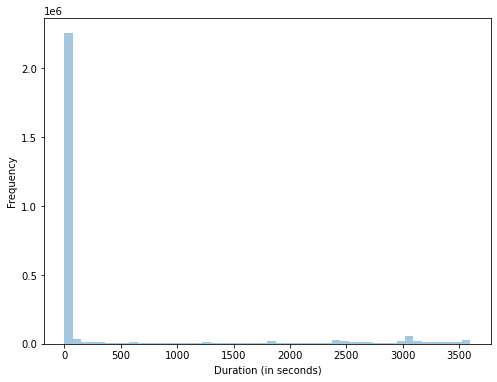

In [82]:
countDur = data['Dur'].apply(lambda x: int(x))
sns.distplot(countDur, kde=False)
plt.xlabel('Duration (in seconds)')
plt.ylabel('Frequency')
plt.show()

2. Majority of the communications last less than 1ms

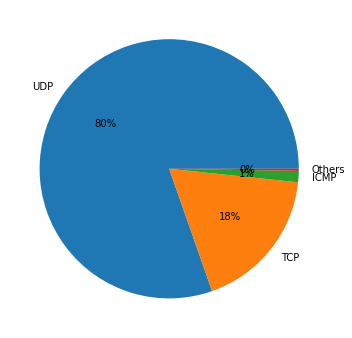

In [12]:
def classifyProto(proto):
    mainLabels = {'udp': 'UDP', 'icmp': 'ICMP', 'tcp': 'TCP'}
    if proto not in mainLabels:
        return 'Others'
    
    return mainLabels[proto]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.18, 0.86, 0.75])
piePlotProto = data['Proto'].apply(classifyProto)
count = piePlotProto.value_counts()
ax.pie(count.values, labels=count.index, autopct='%1.0f%%')
plt.savefig('Fig3.png')
plt.show()

3.Proto: Transport Protocol used (15 protocols in total)

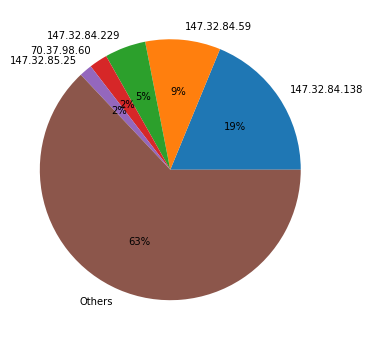

In [59]:
count = data['SrcAddr'].value_counts()[:5]
count['Others'] = len(data) - count.values.sum()
plt.pie(count.values, labels=count.index, autopct='%1.0f%%')
plt.show()

4. The huge number of different IP address (542 093) prevents the categorization based on the feature. Another way needs to be found out

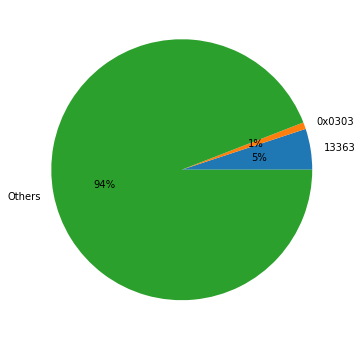

In [13]:
count = data['Sport'].value_counts()[:2]
count['Others'] = len(data) - count.values.sum()
plt.pie(count.values, labels=count.index, autopct='%1.0f%%')
plt.savefig('Fig5.png')
plt.show()

5. The huge number of source port (64 752)

In [63]:
data['Dir'].value_counts() / len(data)

  <->    0.775988
   ->    0.217712
  <-     0.002501
  <?>    0.002186
   ?>    0.001439
  who    0.000170
  <?     0.000002
Name: Dir, dtype: float64

6. **Dir**: Direction of the flow (78% bidirectional, 22% from src to dest)

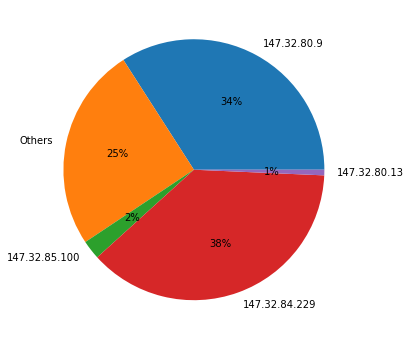

In [14]:
count = data['DstAddr'].value_counts()[:4]
count['Others'] = len(data) - count.values.sum()
count = count.sample(frac=1., random_state=42)
plt.pie(count.values, labels=count.index, autopct='%1.0f%%')
plt.savefig('Fig7.png')
plt.show()

7. The huge number of destination address (119 296)

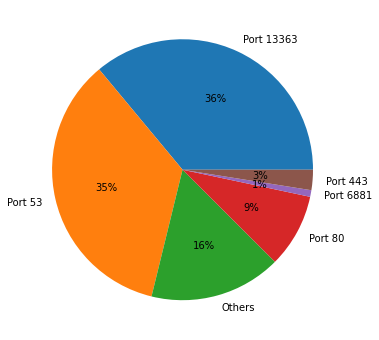

In [15]:
count = data['Dport'].value_counts()[:5]
count['Others'] = len(data) - count.values.sum()
count = count.sample(frac=1., random_state=42)
plt.pie(count.values, labels=[f'Port {x}' if x != 'Others' else x for x in count.index], autopct='%1.0f%%')
plt.savefig('Fig8.png')
plt.show()

8. The huge number of source port (73 786)

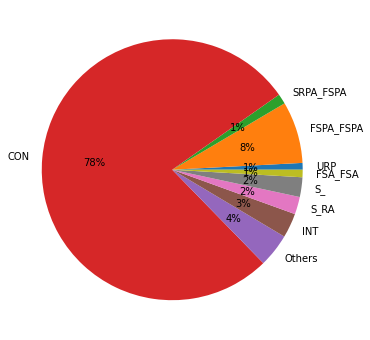

In [16]:
count = data['State'].value_counts()[:8]
count['Others'] = len(data) - count.values.sum()
count = count.sample(frac=1., random_state=42)
plt.pie(count.values, labels=count.index, autopct='%1.0f%%')
plt.savefig('Fig9.png')
plt.show()

9. State: Transaction state (230 states in total)

In [102]:
data['sTos'].value_counts() / len(data)

0.0      0.995074
2.0      0.000478
3.0      0.000341
1.0      0.000224
192.0    0.000133
Name: sTos, dtype: float64

10. sTos: Source TOS byte value (0 for 99.9% of the communications)

In [103]:
data['dTos'].value_counts() / len(data)

0.0    0.930721
2.0    0.000087
3.0    0.000075
1.0    0.000015
Name: dTos, dtype: float64

11. dTos: Dest TOS byte value (0 for 93% of the communications)

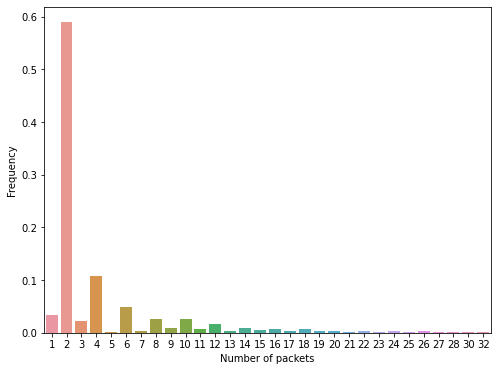

In [6]:
count = data['TotPkts'].value_counts()[:30] / len(data)
sns.barplot(count.index, count.values)
plt.xlabel('Number of packets')
plt.ylabel('Frequency')
plt.savefig('Fig12.png')

12. TotPkts: Total number of transaction Packets (min: 1 packet; max: 2 686 731 packets)

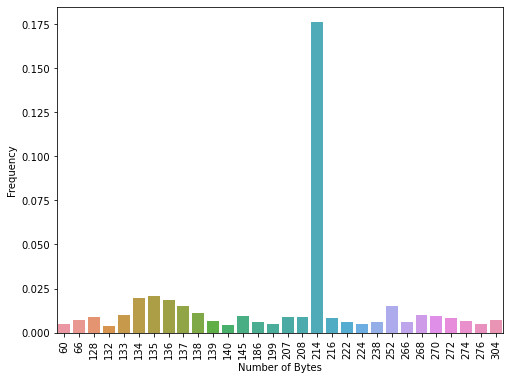

In [7]:
count = data['TotBytes'].value_counts()[:30] / len(data)
ax = sns.barplot(count.index, count.values)
plt.xlabel('Number of Bytes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.savefig('Fig13.png')

13. TotBytes: Total number of transaction Bytes (min: 60 Bytes; max: 2 689 640 464 Bytes)

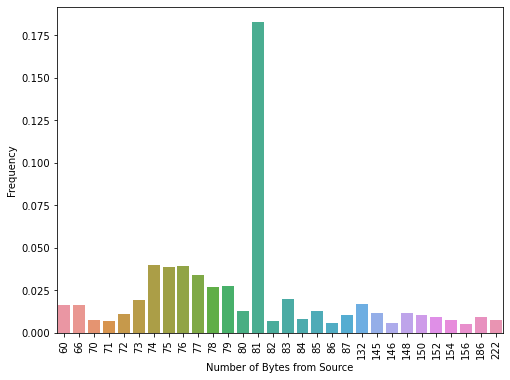

In [8]:
count = data['SrcBytes'].value_counts()[:30] / len(data)
ax = sns.barplot(count.index, count.values)
plt.xlabel('Number of Bytes from Source')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.savefig('Fig14.png')

14. SrcBytes: Total number of transaction Bytes from the Source (min: 0 Byte; max: 2 635 366 235 Bytes)

In [ ]:
labels = ['To-Background', 'From-Botnet', 'From-Normal', 'From-Background', 'To-Normal', 'Normal', 'Background']
def categorizeLabel(x):
    for label in labels:
        if label in x:
            return label
    return None
count = data['Label'].apply(categorizeLabel)
count.value_counts() / count.values.sum()

In [3]:
def categorizeLabel(x):
    if 'Botnet' in x:
        return 'Botnet'
    return 'Normal'

data['Label'] = data['Label'].apply(categorizeLabel)

In [9]:
count = np.load('tmp.npy', allow_pickle=True)
unique, freq = np.unique(count, return_counts=True)
freq = freq / freq.sum()
freq

array([6.32906682e-01, 1.77722014e-04, 1.45013375e-02, 1.07121767e-02,
       3.18625126e-06, 3.41656412e-01, 4.24833501e-05])

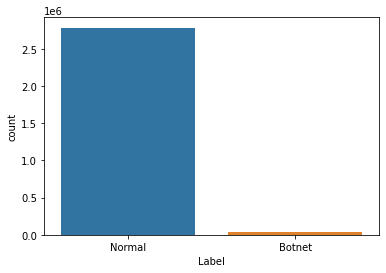

In [7]:
sns.countplot(x='Label', data=data)

15. Distribution of the 113 Labels

## 4.2. Feature Extraction
### 4.2.1. Motivation
The main problem with CTU dataset is that most of the features are categorical. Using one-hot encode results in expansion of storage. It encourages us to extract new features based on the literature of network traffic analysis
### 4.2.2. Use of time windows
- This is justified by the fact that botnets **tend to have a temporal locality behavior**, which enables us to reduce the amount of data
- The main issue is to find out the width and stride of time window which depends on the detection method and is often empirical. As for the dataset, we choose **a time width of 2 minutes and a stride of 1 minutes**

### 4.2.3. Extracted features
- The extracted features represent the Netflow communications inside a time window, so the **time window data is grouped by SrcAddr**
- In terms of categorical features (*Sport*, *DstAddr*, *Dport*, ), 2 features are extracted:
    - The number of unique occurrences in the subgroup
    - The normalized subgroup entropy: $E = -\sum_{x_i \in X} p(x_i) \text{log}p(x_i)$ with $p(x_i) = \frac{\text{#}x_i}{\text{#}X}$
- As for numerical features (), 

In [ ]:
X = pd.DataFrame()
for i in range(data['windowUpper'].max()):
    gb = data.loc[(data['windowLower'] <= i) & (data['windowUpper'] > i)].groupby('SrcAddr')
    X = X.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':'nunique', 
                                                       'DstAddr':'nunique', 
                                                       'Dport':'nunique', 
                                                       'Dur':['sum', 'mean', 'std', 'max', 'median'],
                                                       'TotBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'SrcBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'Label':lambda x: stats.mode(x)[0]})).reset_index().assign(window_id=i))
    print(X.shape)

## 4.3. Feature selection
### 4.3.1. Filter methods
The Pearson Correlation statistical test is used since the pre-processed data involves continuous data

In [15]:
X['Label_<lambda>'].unique()

array([0, 2, 3, 1, 4, 6])

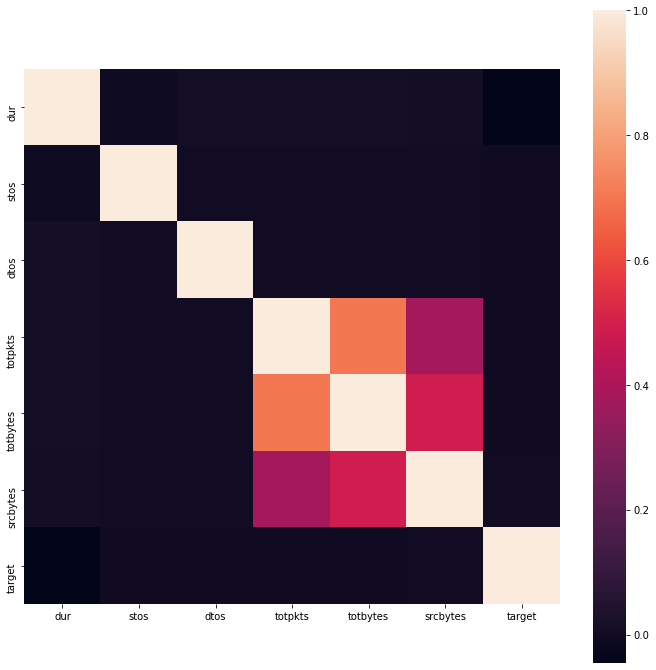

In [19]:
# Plotting the correlation matrix of numerical feature in dataset

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

# EDA #1

- Preprocess program to extract window-related data from Netflow files

- Input:
    - windowWidth / windowStride (in seconds)
    - data: first Netflow files
   
- Output:
    - dataWindowBotnet{id}.h5: 'Sport_nunique',
                            'DstAddr_nunique', 'Dport_nunique',
                            'Dur_sum', 'Dur_mean', 'Dur_std', 'Dur_max', 'Dur_median',
                            'TotBytes_sum', 'TotBytes_mean', 'TotBytes_std', 'TotBytes_max', 'TotBytes_median',
                            'SrcBytes_sum', 'SrcBytes_mean', 'SrcBytes_std', 'SrcBytes_max', 'SrcBytes_median'
    - dataWindowBotnet{id}ID.npy: Numpy arr contain ScrAddr
    - dataWindowBotnet{id}Labels.npy: Numpy arr contain Label

In [4]:
windowWidth, windowStride = 120, 60 # seconds
data['StartTime'].astype('int')

0          1312969619
1          1312969620
2          1312969668
3          1312969668
4          1312969668
              ...    
2824631    1312991647
2824632    1312991647
2824633    1312991647
2824634    1312991647
2824635    1312991647
Name: StartTime, Length: 2824636, dtype: int64

In [5]:
data['windowLower'] = (data['StartTime'] - datatimeStart - windowWidth) / windowStride + 1
data['windowLower']

0           -0.890658
1           -0.873549
2           -0.081029
3           -0.080273
4           -0.068065
              ...    
2824631    366.238419
2824632    366.238443
2824633    366.238500
2824634    366.238659
2824635    366.238684
Name: windowLower, Length: 2824636, dtype: float64

In [6]:
data['windowLower'].clip(lower=0, inplace=True)
data['windowLower']

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
2824631    366.238419
2824632    366.238443
2824633    366.238500
2824634    366.238659
2824635    366.238684
Name: windowLower, Length: 2824636, dtype: float64

In [7]:
data['windowUpper'] = (data['StartTime'] - datatimeStart) / windowStride + 1
data['windowUpper']

0            1.109342
1            1.126451
2            1.918971
3            1.919727
4            1.931935
              ...    
2824631    368.238419
2824632    368.238443
2824633    368.238500
2824634    368.238659
2824635    368.238684
Name: windowUpper, Length: 2824636, dtype: float64

In [8]:
data = data.astype({
    'windowLower': int,
    'windowUpper': int
})

data.drop('StartTime', axis=1, inplace=True)
data.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,windowLower,windowUpper
0,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0,1
1,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0,1
2,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1
3,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1
4,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1


In [9]:
# del(data)
print(pd.factorize(data['Label'].str.slice(0, 15)))
data['Label'], labels = pd.factorize(data['Label'].str.slice(0, 15))

(array([0, 0, 0, ..., 0, 0, 0]), Index(['flow=Background', 'flow=To-Backgro', 'flow=From-Backg',
       'flow=From-Norma', 'flow=To-Normal-', 'flow=Normal-V42',
       'flow=From-Botne'],
      dtype='object'))


In [10]:
X = pd.DataFrame()
for i in range(data['windowUpper'].max()):
    gb = data.loc[(data['windowLower'] <= i) & (data['windowUpper'] > i)].groupby('SrcAddr')
    X = X.append(gb.size().to_frame(name='counts').join(gb.agg({'Sport':'nunique', 
                                                       'DstAddr':'nunique', 
                                                       'Dport':'nunique', 
                                                       'Dur':['sum', 'mean', 'std', 'max', 'median'],
                                                       'TotBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'SrcBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'Label':lambda x: stats.mode(x)[0]})).reset_index().assign(window_id=i))
    print(X.shape)

/home/quan/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(9787, 22)
(18611, 22)
(27165, 22)
(35618, 22)
(44085, 22)
(52590, 22)
(60893, 22)
(69155, 22)
(77348, 22)
(85099, 22)
(92554, 22)
(100050, 22)
(107669, 22)
(115314, 22)
(122838, 22)
(130249, 22)
(137568, 22)
(145031, 22)
(152558, 22)
(159813, 22)
(166800, 22)
(173642, 22)
(180612, 22)
(187548, 22)
(194282, 22)
(201025, 22)
(207690, 22)
(214395, 22)
(221232, 22)
(227866, 22)
(234204, 22)
(240528, 22)
(246838, 22)
(253249, 22)
(259729, 22)
(265888, 22)
(272041, 22)
(278226, 22)
(284193, 22)
(290107, 22)
(295903, 22)
(301515, 22)
(306980, 22)
(312316, 22)
(317715, 22)
(323153, 22)
(328527, 22)
(333850, 22)
(339170, 22)
(344346, 22)
(349213, 22)
(354009, 22)
(358784, 22)
(363468, 22)
(368133, 22)
(372748, 22)
(377513, 22)
(382344, 22)
(387061, 22)
(392084, 22)
(397408, 22)
(402838, 22)
(408440, 22)
(414104, 22)
(419600, 22)
(425073, 22)
(430617, 22)
(436259, 22)
(442075, 22)
(447944, 22)
(453791, 22)
(459609, 22)
(465532, 22)
(471410, 22)
(477195, 22)
(482926, 22)
(488755, 22)
(494764, 22

In [12]:
X.columns = ['_'.join(x) if isinstance(x, tuple) else x for x in X.columns]
X.columns

Index(['SrcAddr', 'counts', 'Sport_nunique', 'DstAddr_nunique',
       'Dport_nunique', 'Dur_sum', 'Dur_mean', 'Dur_std', 'Dur_max',
       'Dur_median', 'TotBytes_sum', 'TotBytes_mean', 'TotBytes_std',
       'TotBytes_max', 'TotBytes_median', 'SrcBytes_sum', 'SrcBytes_mean',
       'SrcBytes_std', 'SrcBytes_max', 'SrcBytes_median', 'Label_<lambda>',
       'window_id'],
      dtype='object')

In [13]:
# std can be nan if only one element
print(len(X[X.isnull().any(axis=1)]) / len(X))
X.fillna(-1, inplace=True)
len(X[X.isnull().any(axis=1)]) / len(X) # no row is null

0.954575339512826


0.0

In [16]:
columnsForNomalization = list(X.columns.values)
columnsForNomalization.remove('SrcAddr')
columnsForNomalization.remove('Label_<lambda>')
columnsForNomalization.remove('window_id')

normalizationFiles = defaultdict(dict)

def normalizeCol(col, df, normalizationFiles):
    normalizationFiles[col]['mean'] = df[col].mean()
    normalizationFiles[col]['std'] = df[col].std()
    df[col] = (df[col] - df[col].mean()) / df[col].std()

for col in columnsForNomalization:
    normalizeCol(col, X, normalizationFiles)

f = open('normalizationFilesWithoutRU.pickle', 'wb')
f.write(pickle.dumps(normalizationFiles))
f.close()

with pd.option_context('display.max_rows', 10, 'display.max_columns', 22):
    print(X.shape)
    print(X)
    print(X.dtypes)

(2226720, 22)
               SrcAddr    counts  Sport_nunique  DstAddr_nunique  \
0              0.0.0.0 -0.019717      -0.027515        -0.025172   
1    00:15:17:2c:e5:2d -0.019717      -0.050986        -0.025172   
2        1.144.156.226 -0.019717      -0.027515        -0.025172   
3           1.144.5.55 -0.019717      -0.027515        -0.025172   
4        1.155.150.224 -0.019717      -0.027515        -0.025172   
..                 ...       ...            ...              ...   
787     99.192.158.141 -0.019717      -0.027515        -0.025172   
788       99.242.24.14 -0.019717      -0.027515        -0.025172   
789     99.245.126.143 -0.019717      -0.027515        -0.025172   
790     99.245.140.246 -0.019717      -0.027515        -0.025172   
791     99.254.184.154 -0.019717      -0.027515        -0.025172   

     Dport_nunique   Dur_sum  Dur_mean   Dur_std   Dur_max  Dur_median  \
0        -0.004666  0.130027  2.268262 -0.090415  2.233044    2.267097   
1        -0.020891  0

In [17]:
# open pickle normalization files
normalizationFiles = pickle.loads(open('normalizationFilesWithRU.pickle', 'rb').read())
normalizationFiles

defaultdict(dict,
            {'counts': {'mean': 2.5321921930013653, 'std': 77.70940856755693},
             'Sport_nunique': {'mean': 2.1722865919379175,
              'std': 42.60578589665009},
             'DstAddr_nunique': {'mean': 1.3124223072501258,
              'std': 12.411583471303741},
             'Dport_nunique': {'mean': 1.287559280017245,
              'std': 61.63164926231007},
             'Dur_sum': {'mean': 1090.604708552082, 'std': 19238.817413699682},
             'Dur_mean': {'mean': 791.1653055265077,
              'std': 1234.8719168333319},
             'Dur_std': {'mean': 11.02408018251827, 'std': 132.98741530501906},
             'Dur_max': {'mean': 806.5069415992403, 'std': 1247.4767493309369},
             'Dur_median': {'mean': 789.8582490939663,
              'std': 1236.0829055040663},
             'TotBytes_sum': {'mean': 48577.96432330962,
              'std': 5815654.790622006},
             'TotBytes_mean': {'mean': 7749.940751521978,
             

In [15]:
X.tail()

,SrcAddr,counts,Sport_nunique,DstAddr_nunique,Dport_nunique,Dur_sum,Dur_mean,Dur_std,Dur_max,Dur_median,...,TotBytes_std,TotBytes_max,TotBytes_median,SrcBytes_sum,SrcBytes_mean,SrcBytes_std,SrcBytes_max,SrcBytes_median,Label_<lambda>,window_id
787,99.192.158.141,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640686,-0.090415,-0.64651,-0.639001,...,-0.003351,-0.007376,-0.003812,-0.003278,-0.002200,-0.001629,-0.002804,-0.001893,0,367
788,99.242.24.14,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,...,-0.003351,-0.007462,-0.004088,-0.003422,-0.002531,-0.001629,-0.002949,-0.002230,0,367
789,99.245.126.143,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,...,-0.003351,-0.007461,-0.004086,-0.003421,-0.002529,-0.001629,-0.002948,-0.002228,0,367
790,99.245.140.246,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,...,-0.003351,-0.007379,-0.003825,-0.003424,-0.002535,-0.001629,-0.002950,-0.002234,0,367
791,99.254.184.154,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,...,-0.003351,-0.007427,-0.003976,-0.003428,-0.002544,-0.001629,-0.002954,-0.002243,0,367


In [17]:
X.drop('SrcAddr', axis=1).to_hdf('dataWindowBotnet0.h5', key='data', mode='w')
np.save('dataWindowBotnet0ID.npy', X['SrcAddr'])
np.save('dataWindowBotnet0Labels.npy', labels)

# EDA #2

- Preprocess program to extract window-related **normalized entropy** from Netflow files

- Input:
    - windowWidth / windowStride (in seconds)
    - data: first Netflow files
   
- Output:
    - dataWindowBotnet{id}.h5: DF with the extracted data: Sport (RU), DstAddr (RU), Dport (RU)
    - dataWindowBotnet{id}ID.npy: Numpy arr contain ScrAddr
    - dataWindowBotnet{id}Labels.npy: Numpy arr contain Label

In [2]:
data = pd.read_csv('CTU-13-Dataset/capture20110810.binetflow', low_memory=False)
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,2011/08/10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,2011/08/10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,2011/08/10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt


In [3]:
data['StartTime'] = pd.to_datetime(data['StartTime']).values.astype('int') * 1e-9
datatimeStart = data['StartTime'].min()
datatimeStart

1312969613.0472772

In [4]:
windowWidth, windowStride = 120, 60 # seconds
data['StartTime'].astype('int')

0          1312969619
1          1312969620
2          1312969668
3          1312969668
4          1312969668
              ...    
2824631    1312991647
2824632    1312991647
2824633    1312991647
2824634    1312991647
2824635    1312991647
Name: StartTime, Length: 2824636, dtype: int64

In [5]:
data['windowLower'] = (data['StartTime'] - datatimeStart - windowWidth) / windowStride + 1
data['windowLower']

0           -0.890658
1           -0.873549
2           -0.081029
3           -0.080273
4           -0.068065
              ...    
2824631    366.238419
2824632    366.238443
2824633    366.238500
2824634    366.238659
2824635    366.238684
Name: windowLower, Length: 2824636, dtype: float64

In [6]:
data['windowLower'].clip(lower=0, inplace=True)
data['windowLower']

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
2824631    366.238419
2824632    366.238443
2824633    366.238500
2824634    366.238659
2824635    366.238684
Name: windowLower, Length: 2824636, dtype: float64

In [7]:
data['windowUpper'] = (data['StartTime'] - datatimeStart) / windowStride + 1
data['windowUpper']

0            1.109342
1            1.126451
2            1.918971
3            1.919727
4            1.931935
              ...    
2824631    368.238419
2824632    368.238443
2824633    368.238500
2824634    368.238659
2824635    368.238684
Name: windowUpper, Length: 2824636, dtype: float64

In [8]:
data = data.astype({
    'windowLower': int,
    'windowUpper': int
})

data.drop('StartTime', axis=1, inplace=True)
data.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,windowLower,windowUpper
0,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0,1
1,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT,0,1
2,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1
3,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1
4,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt,0,1


In [9]:
# del(data)
print(pd.factorize(data['Label'].str.slice(0, 15)))
data['Label'], labels = pd.factorize(data['Label'].str.slice(0, 15))

(array([0, 0, 0, ..., 0, 0, 0]), Index(['flow=Background', 'flow=To-Backgro', 'flow=From-Backg',
       'flow=From-Norma', 'flow=To-Normal-', 'flow=Normal-V42',
       'flow=From-Botne'],
      dtype='object'))


In [10]:
def RU(df):
    if df.shape[0] == 1:
        return 1.
    
    prob = df.value_counts() / df.shape[0]
    h = prob * np.log10(prob)
    return -h.sum() / np.log10(df.shape[0])

In [11]:
X = pd.DataFrame()

for i in range(data['windowUpper'].max()):
    gb = data[(data['windowLower'] <= i) & (data['windowUpper'] > i)].groupby('SrcAddr')
    X = X.append(gb.agg({
        'Sport': [RU],
        'DstAddr': [RU],
        'Dport': [RU]
    }).reset_index())
    print(X.shape)

(9787, 4)
(18611, 4)
(27165, 4)
(35618, 4)
(44085, 4)
(52590, 4)
(60893, 4)
(69155, 4)
(77348, 4)
(85099, 4)
(92554, 4)
(100050, 4)
(107669, 4)
(115314, 4)
(122838, 4)
(130249, 4)
(137568, 4)
(145031, 4)
(152558, 4)
(159813, 4)
(166800, 4)
(173642, 4)
(180612, 4)
(187548, 4)
(194282, 4)
(201025, 4)
(207690, 4)
(214395, 4)
(221232, 4)
(227866, 4)
(234204, 4)
(240528, 4)
(246838, 4)
(253249, 4)
(259729, 4)
(265888, 4)
(272041, 4)
(278226, 4)
(284193, 4)
(290107, 4)
(295903, 4)
(301515, 4)
(306980, 4)
(312316, 4)
(317715, 4)
(323153, 4)
(328527, 4)
(333850, 4)
(339170, 4)
(344346, 4)
(349213, 4)
(354009, 4)
(358784, 4)
(363468, 4)
(368133, 4)
(372748, 4)
(377513, 4)
(382344, 4)
(387061, 4)
(392084, 4)
(397408, 4)
(402838, 4)
(408440, 4)
(414104, 4)
(419600, 4)
(425073, 4)
(430617, 4)
(436259, 4)
(442075, 4)
(447944, 4)
(453791, 4)
(459609, 4)
(465532, 4)
(471410, 4)
(477195, 4)
(482926, 4)
(488755, 4)
(494764, 4)
(500735, 4)
(506756, 4)
(512858, 4)
(518825, 4)
(524757, 4)
(530697, 4)
(536

In [13]:
X.columns = ['_'.join(x) if isinstance(x, tuple) else x for x in X.columns]
X.columns

Index(['SrcAddr_', 'Sport_RU', 'DstAddr_RU', 'Dport_RU'], dtype='object')

In [15]:
columnsForNomalization = list(X.columns.values)
columnsForNomalization.remove('SrcAddr_')

# normalizationFiles = defaultdict(dict)

def normalizeCol(col, df, normalizationFiles):
    normalizationFiles[col]['mean'] = df[col].mean()
    normalizationFiles[col]['std'] = df[col].std()
    df[col] = (df[col] - df[col].mean()) / df[col].std()

for col in columnsForNomalization:
    normalizeCol(col, X, normalizationFiles)

with pd.option_context('display.max_rows', 10, 'display.max_columns', 22):
    print(X.shape)
    print(X)
    print(X.dtypes)

(2226720, 4)
              SrcAddr_  Sport_RU  DstAddr_RU  Dport_RU
0              0.0.0.0  0.079879     0.20136  0.186766
1    00:15:17:2c:e5:2d  0.079879     0.20136  0.186766
2        1.144.156.226  0.079879     0.20136  0.186766
3           1.144.5.55  0.079879     0.20136  0.186766
4        1.155.150.224  0.079879     0.20136  0.186766
..                 ...       ...         ...       ...
787     99.192.158.141  0.079879     0.20136  0.186766
788       99.242.24.14  0.079879     0.20136  0.186766
789     99.245.126.143  0.079879     0.20136  0.186766
790     99.245.140.246  0.079879     0.20136  0.186766
791     99.254.184.154  0.079879     0.20136  0.186766

[2226720 rows x 4 columns]
SrcAddr_       object
Sport_RU      float64
DstAddr_RU    float64
Dport_RU      float64
dtype: object


In [16]:
f = open('normalizationFilesWithRU.pickle', 'wb')
f.write(pickle.dumps(normalizationFiles))
f.close()

In [14]:
X.tail()

,SrcAddr_,Sport_RU,DstAddr_RU,Dport_RU
787,99.192.158.141,0.079879,0.20136,0.186766
788,99.242.24.14,0.079879,0.20136,0.186766
789,99.245.126.143,0.079879,0.20136,0.186766
790,99.245.140.246,0.079879,0.20136,0.186766
791,99.254.184.154,0.079879,0.20136,0.186766


In [16]:
X.drop('SrcAddr_', axis=1).to_hdf('dataWindowBotnet0WithRU.h5', key='data', mode='w')
np.save('dataWindowBotnet0IDWithRU.npy', X['SrcAddr_'])
np.save('dataWindowBotnet0LabelsWithRU.npy', labels)

# Feature Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, classification_report

- Use different methods to extract relevant features
    -Lasso and Ridge Logistic Regression
    - SVM with Recursive Feature Elimination

- Input
    - dataWindowBotnet0.h5: preprocessed data without RU
    - dataWindowBotnet0WithRU.h5: preprocessed data with RU
    - dataWindowBotnet0Labels.npy: label numpy

In [3]:
X = pd.read_hdf('dataWindowBotnet0.h5', key='data')
X.reset_index(drop=True, inplace=True)
X.tail()

,counts,Sport_nunique,DstAddr_nunique,Dport_nunique,Dur_sum,Dur_mean,Dur_std,Dur_max,Dur_median,TotBytes_sum,...,TotBytes_std,TotBytes_max,TotBytes_median,SrcBytes_sum,SrcBytes_mean,SrcBytes_std,SrcBytes_max,SrcBytes_median,Label_<lambda>,window_id
2226715,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640686,-0.090415,-0.64651,-0.639001,-0.008255,...,-0.003351,-0.007376,-0.003812,-0.003278,-0.002200,-0.001629,-0.002804,-0.001893,0,367
2226716,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,-0.008329,...,-0.003351,-0.007462,-0.004088,-0.003422,-0.002531,-0.001629,-0.002949,-0.002230,0,367
2226717,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,-0.008328,...,-0.003351,-0.007461,-0.004086,-0.003421,-0.002529,-0.001629,-0.002948,-0.002228,0,367
2226718,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,-0.008259,...,-0.003351,-0.007379,-0.003825,-0.003424,-0.002535,-0.001629,-0.002950,-0.002234,0,367
2226719,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.64651,-0.639000,-0.008299,...,-0.003351,-0.007427,-0.003976,-0.003428,-0.002544,-0.001629,-0.002954,-0.002243,0,367


In [4]:
XWithRU = pd.read_hdf('dataWindowBotnet0WithRU.h5', key='data')
XWithRU.reset_index(drop=True, inplace=True)
XWithRU.head()

,Sport_RU,DstAddr_RU,Dport_RU
0,0.079879,0.20136,0.186766
1,0.079879,0.20136,0.186766
2,0.079879,0.20136,0.186766
3,0.079879,0.20136,0.186766
4,0.079879,0.20136,0.186766


In [5]:
X = X.join(XWithRU)
X.head()

,counts,Sport_nunique,DstAddr_nunique,Dport_nunique,Dur_sum,Dur_mean,Dur_std,Dur_max,Dur_median,TotBytes_sum,...,SrcBytes_sum,SrcBytes_mean,SrcBytes_std,SrcBytes_max,SrcBytes_median,Label_<lambda>,window_id,Sport_RU,DstAddr_RU,Dport_RU
0,-0.019717,-0.027515,-0.025172,-0.004666,0.130027,2.268262,-0.090415,2.233044,2.267097,0.011943,...,0.036407,0.088680,-0.001629,0.037010,0.090695,0,0,0.079879,0.20136,0.186766
1,-0.019717,-0.050986,-0.025172,-0.020891,0.130070,2.268927,-0.090415,2.233703,2.267762,0.000671,...,0.014272,0.037990,-0.001629,0.014803,0.039052,0,0,0.079879,0.20136,0.186766
2,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640684,-0.090415,-0.646508,-0.638999,-0.008330,...,-0.003425,-0.002537,-0.001629,-0.002951,-0.002236,0,0,0.079879,0.20136,0.186766
3,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640684,-0.090415,-0.646508,-0.638999,-0.008261,...,-0.003289,-0.002226,-0.001629,-0.002815,-0.001919,0,0,0.079879,0.20136,0.186766
4,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.646510,-0.639000,-0.008330,...,-0.003424,-0.002536,-0.001629,-0.002951,-0.002235,0,0,0.079879,0.20136,0.186766


In [6]:
X.drop('window_id', axis=1, inplace=True)
X.head()

,counts,Sport_nunique,DstAddr_nunique,Dport_nunique,Dur_sum,Dur_mean,Dur_std,Dur_max,Dur_median,TotBytes_sum,...,TotBytes_median,SrcBytes_sum,SrcBytes_mean,SrcBytes_std,SrcBytes_max,SrcBytes_median,Label_<lambda>,Sport_RU,DstAddr_RU,Dport_RU
0,-0.019717,-0.027515,-0.025172,-0.004666,0.130027,2.268262,-0.090415,2.233044,2.267097,0.011943,...,0.071832,0.036407,0.088680,-0.001629,0.037010,0.090695,0,0.079879,0.20136,0.186766
1,-0.019717,-0.050986,-0.025172,-0.020891,0.130070,2.268927,-0.090415,2.233703,2.267762,0.000671,...,0.029619,0.014272,0.037990,-0.001629,0.014803,0.039052,0,0.079879,0.20136,0.186766
2,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640684,-0.090415,-0.646508,-0.638999,-0.008330,...,-0.004093,-0.003425,-0.002537,-0.001629,-0.002951,-0.002236,0,0.079879,0.20136,0.186766
3,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640684,-0.090415,-0.646508,-0.638999,-0.008261,...,-0.003834,-0.003289,-0.002226,-0.001629,-0.002815,-0.001919,0,0.079879,0.20136,0.186766
4,-0.019717,-0.027515,-0.025172,-0.004666,-0.056688,-0.640685,-0.090415,-0.646510,-0.639000,-0.008330,...,-0.004092,-0.003424,-0.002536,-0.001629,-0.002951,-0.002235,0,0.079879,0.20136,0.186766


In [6]:
y = X['Label_<lambda>']
X.drop('Label_<lambda>', axis=1, inplace=True)

In [7]:
labels = np.load('dataWindowBotnet0Labels.npy', allow_pickle=True)
labels

array(['flow=Background', 'flow=To-Backgro', 'flow=From-Backg',
       'flow=From-Norma', 'flow=To-Normal-', 'flow=Normal-V42',
       'flow=From-Botne'], dtype=object)

In [9]:
X.columns.values

array(['counts', 'Sport_nunique', 'DstAddr_nunique', 'Dport_nunique',
       'Dur_sum', 'Dur_mean', 'Dur_std', 'Dur_max', 'Dur_median',
       'TotBytes_sum', 'TotBytes_mean', 'TotBytes_std', 'TotBytes_max',
       'TotBytes_median', 'SrcBytes_sum', 'SrcBytes_mean', 'SrcBytes_std',
       'SrcBytes_max', 'SrcBytes_median', 'Sport_RU', 'DstAddr_RU',
       'Dport_RU'], dtype=object)

In [16]:
y.unique()

array([0, 2, 3, 1, 4, 6])

In [8]:
yBin6 = (y == 6)
trainX, testX, trainY, testY = train_test_split(X, yBin6, test_size=0.33, random_state=42)

In [19]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 6]),
 array([2207092,   18047,     263,     984,      48,     286]))

In [20]:
np.unique(trainY, return_counts=True)

(array([False,  True]), array([1491686,     216]))

In [21]:
np.unique(testY, return_counts=True)

(array([False,  True]), array([734748,     70]))

In [11]:
clf = LogisticRegression(random_state=42, max_iter=1000, verbose=1, n_jobs=-1)
clf.fit(trainX, trainY)
print(clf.coef_)
print(clf.intercept_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[-2.16997286e+00  5.87285739e-01  2.08464495e+00 -9.56591226e+00
  -2.73605192e+00 -1.64968846e+00 -7.55006548e-01  2.09327975e+00
  -1.52409842e+00 -4.66473425e+00 -6.88930171e-02  6.46356760e-03
  -2.38881822e+00 -1.11505338e-01  9.67097690e-02 -2.32814376e-02
   1.23352284e-01  7.06595453e-01 -4.13407832e-02 -1.08990927e-02
   5.50569765e-01 -1.15962562e+00]]
[-11.85821628]


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


In [12]:
predY = clf.predict(testX)
print(f'Balanced accuracy score: {balanced_accuracy_score(testY, predY)}')

Balanced accuracy score: 0.8071367325940322


In [13]:
print(classification_report(testY, predY))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    734748
        True       0.83      0.61      0.70        70

    accuracy                           1.00    734818
   macro avg       0.91      0.81      0.85    734818
weighted avg       1.00      1.00      1.00    734818



In [14]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(testY, predY)
print("precision = ", precision[1])
print("recall = ", recall[1])
print("fbeta_score = ", fbeta_score[1])
print("support = ", support[1])

precision =  0.8269230769230769
recall =  0.6142857142857143
fbeta_score =  0.7049180327868853
support =  70


In [15]:
clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', verbose=1, n_jobs=-1)
clf.fit(trainX, trainY)
print(clf.coef_)
print(clf.intercept_)

predY = clf.predict(testX)
print(f'Balanced accuracy score: {balanced_accuracy_score(testY, predY)}')
print(classification_report(testY, predY))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.3min finished


[[ -5.14765132   1.28336298   6.53377604 -26.57477613 -19.18948359
  -24.07105747   1.28086773   1.56713231  -4.60119712  -4.32918278
   -0.36872127   3.30648504   0.05855307  -1.55328972  -6.58352068
   -0.23227656   0.068309    -0.5344584   -0.55087879  -0.36517028
   -0.09164185  -0.39231816]]
[-23.96304019]
Balanced accuracy score: 0.9847826737874754
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    734748
        True       0.05      0.97      0.09        70

    accuracy                           1.00    734818
   macro avg       0.52      0.98      0.54    734818
weighted avg       1.00      1.00      1.00    734818



In [38]:
clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: .5, 1: .5}, verbose=1, n_jobs=-1)
clf.fit(trainX, trainY)
print(clf.coef_)
print(clf.intercept_)

predY = clf.predict(testX)
print(f'Balanced accuracy score: {balanced_accuracy_score(testY, predY)}')
print(classification_report(testY, predY))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.0min finished


[[-6.16545590e-05 -7.22643147e-05 -5.85310625e-05 -7.12486173e-05
  -1.74199104e-03 -1.99200422e-03  8.01850378e-05 -1.91440131e-03
  -1.99286047e-03  5.27832419e-05 -1.07314601e-02  1.57944518e-03
  -8.89456933e-05 -1.09615284e-02 -1.34611211e-03 -6.02171948e-03
   7.07051048e-04 -2.01343590e-03 -6.08757474e-03  9.97684849e-04
   3.14700273e-04  3.50914715e-04]]
[-7.31210254e-05]
Balanced accuracy score: 0.49999863898915003
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    734748
        True       0.00      0.00      0.00        70

    accuracy                           1.00    734818
   macro avg       0.50      0.50      0.50    734818
weighted avg       1.00      1.00      1.00    734818



## Comments
- With `class_weight='balanced`, very high recall but very low precision
- Without `balanced` mode, low precision along with recall
- accuracy is not a good metric, even balanced one

In [10]:
# def applyLogRegCV(X, Y, **logRegArgs):
#     clf = LogisticRegression(logRegArgs)
#     print(clf)
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     scores = cross_validate(clf, X, Y, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, verbose=0, return_train_score=True)

#     precision = cross_val_score(clf, X, Y, cv=3, n_jobs=-1, scoring='precision')
#     recall = cross_val_score(clf, X, Y, cv=3, n_jobs=-1, scoring='recall')
#     f1 = cross_val_score(clf, X, Y, cv=3, n_jobs=-1, scoring='f1')
    
#     return precision, recall, f1

In [16]:
searchClassWeight = np.linspace(0, .1, 10)
print(searchClassWeight)

[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ]


In [9]:
# searchScores = []
# for classWeight in list(searchClassWeight[0:2]):
#     searchScores.append(applyLogRegCV(trainX, trainY, random_state=42, max_iter=1000,
#                                       class_weight={0: classWeight, 1: 1 - classWeight}, verbose=1, n_jobs=-1))
# print(searchScores)

In [17]:
searchClassWeight

array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ])

In [18]:
searchScores = []

for classWeight in searchClassWeight:
    clf = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: classWeight, 1: 1 - classWeight}, verbose=1, n_jobs=-1)
    print(clf)
    
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    scores = cross_validate(clf, trainX, trainY, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, verbose=0, return_train_score=True)
    
    searchScores.append([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
    print(searchScores[-1])
    print('-'*44)

LogisticRegression(class_weight={0: 0.0, 1: 1.0}, max_iter=1000, n_jobs=-1,
                   random_state=42, verbose=1)
[0.00015550535890234668, 1.0, 0.00031096205971767934]
--------------------------------------------
LogisticRegression(class_weight={0: 0.011111111111111112,
                                 1: 0.9888888888888889},
                   max_iter=1000, n_jobs=-1, random_state=42, verbose=1)
[0.23313857390357318, 0.9488246536072623, 0.3738643650088235]
--------------------------------------------
LogisticRegression(class_weight={0: 0.022222222222222223,
                                 1: 0.9777777777777777},
                   max_iter=1000, n_jobs=-1, random_state=42, verbose=1)
[0.39930731031368244, 0.9488246536072623, 0.5603929393358787]
--------------------------------------------
LogisticRegression(class_weight={0: 0.03333333333333333, 1: 0.9666666666666667},
                   max_iter=1000, n_jobs=-1, random_state=42, verbose=1)
[0.48508576230831757, 0.9488246536

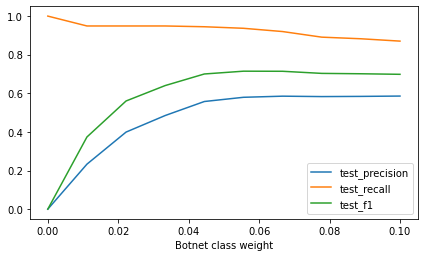

In [22]:
plt.plot(searchClassWeight, [searchScore[0] for searchScore in searchScores])
plt.plot(searchClassWeight, [searchScore[1] for searchScore in searchScores])
plt.plot(searchClassWeight, [searchScore[2] for searchScore in searchScores])
plt.legend(['test_precision', 'test_recall', 'test_f1'])
plt.xlabel('Botnet class weight')

plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig('crossValidationClassWeight.png', format='png')
plt.show()

In [23]:
searchForC = np.logspace(-2, 6, 9)
searchForC

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])

In [24]:
searchForTabC = np.log10(searchForC)
searchForTabC

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [26]:
scoresForC = []

for C in searchForC:
    clf = LogisticRegression(C=C, class_weight={0: 0.05, 1: 1 - 0.05}, random_state=42, max_iter=1000, n_jobs=-1)
    print(clf)
    
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    scores = cross_validate(clf, trainX, trainY, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, return_train_score=True, return_estimator=True)
    print(scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean())
    scoresForC.append([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean(),\
                       np.mean([model.coef_[0] for model in scores['estimator']], axis=0)])
    print('-'*100)

LogisticRegression(C=0.01, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.12963254844708733 0.20688068453285843 0.1583524380240929
----------------------------------------------------------------------------------------------------
LogisticRegression(C=0.1, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.20884772205151708 0.726901012031447 0.3239876870142746
----------------------------------------------------------------------------------------------------
LogisticRegression(class_weight={0: 0.05, 1: 0.95}, max_iter=1000, n_jobs=-1,
                   random_state=42)
0.5744879698904466 0.9408246536072623 0.7120047368738747
----------------------------------------------------------------------------------------------------
LogisticRegression(C=10.0, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.7465175388200972 0.9495865583691669 0.83356

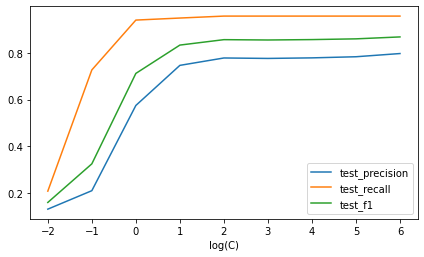

In [28]:
np.save('scoresForC.npy', np.array(scoresForC))

plt.plot(searchForTabC, [score[0] for score in scoresForC])
plt.plot(searchForTabC, [score[1] for score in scoresForC])
plt.plot(searchForTabC, [score[2] for score in scoresForC])
plt.legend(['test_precision', 'test_recall', 'test_f1'])

plt.xlabel('log(C)')

plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig('crossValidationForC.png', format='png')
plt.show()

In [30]:
searchForLinearC = np.linspace(100, 1000, 10)
scoresForLinearC = []

for C in searchForLinearC:
    clf = LogisticRegression(C=C, class_weight={0: 0.05, 1: 1 - 0.05}, random_state=42, max_iter=1000, n_jobs=-1)
    print(clf)
    
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    scores = cross_validate(clf, trainX, trainY, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, return_train_score=True, return_estimator=True)
    print(scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean())
    scoresForLinearC.append([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean(),\
                       np.mean([model.coef_[0] for model in scores['estimator']], axis=0)])
    print('-'*100)

LogisticRegression(C=100.0, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.7782264430971327 0.9579343844561234 0.8568359869957858
----------------------------------------------------------------------------------------------------
LogisticRegression(C=200.0, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.7778816155109258 0.9579343844561234 0.8567355288154165
----------------------------------------------------------------------------------------------------
LogisticRegression(C=300.0, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.7778816155109258 0.9579343844561234 0.8567355288154165
----------------------------------------------------------------------------------------------------
LogisticRegression(C=400.0, class_weight={0: 0.05, 1: 0.95}, max_iter=1000,
                   n_jobs=-1, random_state=42)
0.7778816155109258 0.9579343844561

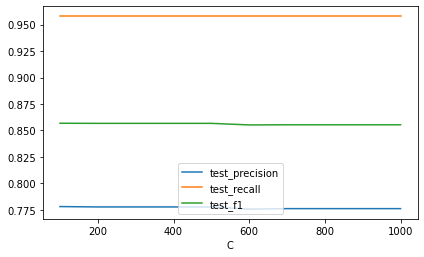

In [31]:
np.save('scoresForLinearC.npy', np.array(scoresForC))

plt.plot(searchForLinearC, [score[0] for score in scoresForLinearC])
plt.plot(searchForLinearC, [score[1] for score in scoresForLinearC])
plt.plot(searchForLinearC, [score[2] for score in scoresForLinearC])
plt.legend(['test_precision', 'test_recall', 'test_f1'])

plt.xlabel('C')

plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig('crossValidationForLinearC.png', format='png')
plt.show()

#### SVM method with RFE

In [17]:
def rfeSVM(X, y):
    clf = SGDClassifier(penalty='elasticnet', alpha=1e-9, n_jobs=-1, random_state=42,class_weight={0: 0.05, 1: 1 - 0.05})
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    
    nFeatures = X.shape[1]
    print(nFeatures)

    scores = cross_validate(clf, X, y, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, return_train_score=True)
    print(nFeatures, scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean())
    print('-'*100)

    if nFeatures > 1:
        rfe = RFE(clf, n_features_to_select=nFeatures - 1, step=1)
        rfe.fit(X, y)
        output = rfeSVM(rfe.transform(X), y)
        
        output.append([nFeatures, scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean(), rfe.support_, rfe.ranking_])
        return output
    else:
        return [[nFeatures, scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean(), [True], [1]]]

In [18]:
results = np.array(rfeSVM(trainX, trainY))
results

22
22 0.7922835178869663 0.957191301452171 0.859710088796715
----------------------------------------------------------------------------------------------------
21
21 0.8239467620502104 0.9531913014521709 0.8719390042610685
----------------------------------------------------------------------------------------------------
20
20 0.8480846930846931 0.9488434753652143 0.8827781651002293
----------------------------------------------------------------------------------------------------
19
19 0.8209600861070625 0.9247595303247478 0.8363459411414841
----------------------------------------------------------------------------------------------------
18
18 0.7941146410339959 0.9274510417119114 0.8412060184308101
----------------------------------------------------------------------------------------------------
17
17 0.8054670287969469 0.9045073187681885 0.8333458110053854
----------------------------------------------------------------------------------------------------
16
16 0.8426880493

array([[1, 0.0, 0.0, 0.0, list([True]), list([1])],
       [2, 0.0, 0.0, 0.0, array([ True, False]), array([1, 2])],
       [3, 0.0, 0.0, 0.0, array([ True, False,  True]), array([1, 2, 1])],
       [4, 0.0, 0.0, 0.0, array([False,  True,  True,  True]),
        array([2, 1, 1, 1])],
       [5, 0.7443406513567804, 0.9404518669736059, 0.8133692326950885,
        array([False,  True,  True,  True,  True]),
        array([2, 1, 1, 1, 1])],
       [6, 0.6387675800200784, 0.966021978021978, 0.7442696490179974,
        array([ True,  True,  True, False,  True,  True]),
        array([1, 1, 1, 2, 1, 1])],
       [7, 0.6923185446413792, 0.9266265328874026, 0.7519613511147187,
        array([ True,  True,  True,  True, False,  True,  True]),
        array([1, 1, 1, 1, 2, 1, 1])],
       [8, 0.6432682571277396, 0.9659343844561235, 0.7514062838407142,
        array([ True,  True,  True,  True, False,  True,  True,  True]),
        array([1, 1, 1, 1, 2, 1, 1, 1])],
       [9, 0.6180852871981874, 0

In [19]:
np.save('rfeSVM.npy', np.array(results))

In [20]:
searchClassWeight = np.linspace(0, .1, 10)
scoresForSVM = []

for classWeight in searchClassWeight:
    clf = SGDClassifier(penalty='elasticnet', alpha=1e-9, n_jobs=-1, random_state=42,class_weight={0: classWeight, 1: 1 - classWeight})
    print(clf)
    
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    scores = cross_validate(clf, trainX, trainY, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, return_train_score=True)
    print(scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean())
    scoresForSVM.append([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
    print('-'*100)

SGDClassifier(alpha=1e-09, class_weight={0: 0.0, 1: 1.0}, n_jobs=-1,
              penalty='elasticnet', random_state=42)
0.00015550535890234668 1.0 0.00031096205971767934
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-09,
              class_weight={0: 0.011111111111111112, 1: 0.9888888888888889},
              n_jobs=-1, penalty='elasticnet', random_state=42)
0.5241402188989601 0.9651062271062271 0.6551127620944677
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-09,
              class_weight={0: 0.022222222222222223, 1: 0.9777777777777777},
              n_jobs=-1, penalty='elasticnet', random_state=42)
0.693161646495164 0.9582822105430802 0.787628893096193
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-09,
              class_weight={0: 0.03333333333333333

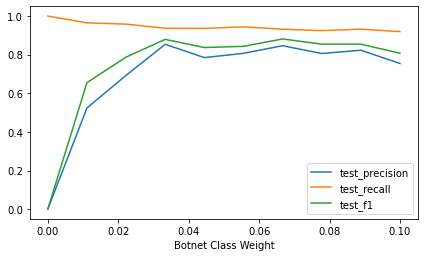

In [21]:
plt.plot(searchClassWeight, [score[0] for score in scoresForSVM])
plt.plot(searchClassWeight, [score[1] for score in scoresForSVM])
plt.plot(searchClassWeight, [score[2] for score in scoresForSVM])
plt.legend(['test_precision', 'test_recall', 'test_f1'])

plt.xlabel('Botnet Class Weight')

plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig('crossValidationClassWeightSVM.png', format='png')
plt.show()

0.033

In [ ]:
searchForC = np.logspace(-16, -4, 13)

scoresForC = []

for C in searchForC:
    clf = SGDClassifier(penalty='elasticnet', alpha=C, n_jobs=-1, random_state=42,class_weight={0: 0.033, 1: 1 - 0.033})
    print(clf)
    
    cv = ShuffleSplit(n_splits=10, test_size=.1, random_state=42)
    scores = cross_validate(clf, trainX, trainY, scoring=['precision', 'recall', 'f1'], cv=cv, n_jobs=-1, return_train_score=True)
    print(scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean())
    scoresForC.append([scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()])
    print('-'*100)

SGDClassifier(alpha=1e-16, class_weight={0: 0.033, 1: 0.967}, n_jobs=-1,
              penalty='elasticnet', random_state=42)
0.7086275233859844 0.943714922758401 0.7784844398072166
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-15, class_weight={0: 0.033, 1: 0.967}, n_jobs=-1,
              penalty='elasticnet', random_state=42)
0.7290297012624442 0.9367182672400064 0.7989393683735528
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-14, class_weight={0: 0.033, 1: 0.967}, n_jobs=-1,
              penalty='elasticnet', random_state=42)
0.8052786339930267 0.9076486701704093 0.8313218702699106
----------------------------------------------------------------------------------------------------
SGDClassifier(alpha=1e-13, class_weight={0: 0.033, 1: 0.967}, n_jobs=-1,
              penalty='elasticnet', random_state=42)
0.7085271975245678 0.94

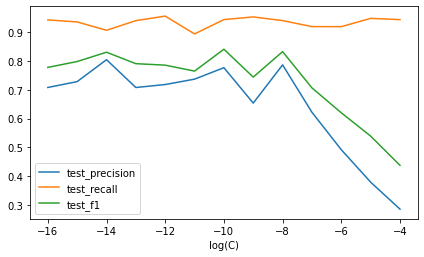

In [32]:
np.save('scoresForSVMAlpha.npy', np.array(scoresForC))

plt.plot(np.log10(searchForC), [score[0] for score in scoresForC])
plt.plot(np.log10(searchForC), [score[1] for score in scoresForC])
plt.plot(np.log10(searchForC), [score[2] for score in scoresForC])
plt.legend(['test_precision', 'test_recall', 'test_f1'])

plt.xlabel('log(C)')

plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig('crossValidationForSVMAlpha.png', format='png')
plt.show()